In [1]:
## Necessary packages
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import warnings
warnings.filterwarnings("ignore")

# 1. TimeGAN model
from timegan import timegan
# 2. Data loading
from data_loading import real_data_loading_sce2, sine_data_generation_sce2
# 3. Metrics
from metrics.discriminative_metrics import discriminative_score_metrics
from metrics.predictive_metrics import predictive_score_metrics
from metrics.visualization_metrics import visualization

import tensorflow as tf

import os, time

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
config = tf.compat.v1.ConfigProto() # Another Version: config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [3]:
## Data loading
data_name = 'sines'
seq_len = 24
test_per = 0.05 # testing percentage: 5%
observe_per = 0.50 # 10% of most recent 

if data_name in ['stock', 'energy']:
    train_data, test_data = real_data_loading_sce2(data_name, seq_len, test_per, observe_per)
elif data_name == 'sines':
    # Set number of samples and its dimensions
    no, dim = 10000, 5
    train_data, test_data = sine_data_generation_sce2(no, seq_len, dim, test_per, observe_per)
    
print(data_name + ' dataset is ready.')

sines dataset is ready.


In [4]:
np.array(train_data).shape, np.array(test_data).shape

((4750, 24, 5), (500, 24, 5))

In [5]:
## Newtork parameters
parameters = dict()

parameters['module'] = 'gru' 
parameters['hidden_dim'] = 20
parameters['num_layer'] = 3
parameters['iterations'] = 5000
parameters['batch_size'] = 128

In [6]:
# Run TimeGAN
start = time.time()
generated_data = timegan(train_data, parameters)   
end = time.time()
print('Finish Synthetic Data Generation')
print(f"Runtime of the Generator is {end - start}")





Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons


2021-08-19 02:22:46.816548: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-08-19 02:22:46.861636: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla V100-PCIE-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.38
pciBusID: 0000:5e:00.0
2021-08-19 02:22:46.861855: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-08-19 02:22:46.863235: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2021-08-19 02:22:46.864618: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2021-08-19 02:22:46.864921: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2021-08-19 02:22:46.866560: I tensorflow/stream_executor/platfo

Start Embedding Network Training


2021-08-19 02:22:49.635642: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0


step: 0/5000, e_loss: 0.3193
step: 1000/5000, e_loss: 0.0534
step: 2000/5000, e_loss: 0.0357
step: 3000/5000, e_loss: 0.0313
step: 4000/5000, e_loss: 0.0306
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/5000, s_loss: 0.1781
step: 1000/5000, s_loss: 0.019
step: 2000/5000, s_loss: 0.0134
step: 3000/5000, s_loss: 0.0108
step: 4000/5000, s_loss: 0.0094
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/5000, d_loss: 2.2051, g_loss_u: 0.591, g_loss_s: 0.0212, g_loss_v: 0.3732, e_loss_t0: 0.1263
step: 1000/5000, d_loss: 1.868, g_loss_u: 1.0139, g_loss_s: 0.0189, g_loss_v: 0.037, e_loss_t0: 0.0206
step: 2000/5000, d_loss: 1.5464, g_loss_u: 1.3975, g_loss_s: 0.0241, g_loss_v: 0.0381, e_loss_t0: 0.017
step: 3000/5000, d_loss: 1.5768, g_loss_u: 1.2937, g_loss_s: 0.022, g_loss_v: 0.0339, e_loss_t0: 0.0131
step: 4000/5000, d_loss: 1.4701, g_loss_u: 1.4895, g_loss_s: 0.0181, g_loss_v: 0.0472, e_loss_t0: 0.0116
Finish Joint Training
Finish Syn

In [7]:
filename = data_name + "_data_TimeGAN_5000_sce2-wTest-0-020.npy"
np.save(filename, generated_data)

In [8]:
generated_data.shape

(394250, 24, 5)

In [9]:
generated_data[0][0]

array([0.51691992, 0.51718369, 0.54497991, 0.51905421, 0.51962638])

In [10]:
metric_iteration = 5

predictive_score = list()
time_usage = list()
for tt in range(metric_iteration):
    start = time.time()
    temp_pred = predictive_score_metrics(test_data, generated_data)
    end = time.time()
    predictive_score.append(temp_pred)
    time_usage.append(end-start)
    
print('Predictive score: ' + str(np.round(np.mean(predictive_score), 4)))

Instructions for updating:
Please use tf.global_variables instead.



2021-08-19 03:52:21.908708: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1618] Found device 0 with properties: 
name: Tesla V100-PCIE-32GB major: 7 minor: 0 memoryClockRate(GHz): 1.38
pciBusID: 0000:5e:00.0
2021-08-19 03:52:21.908796: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.0
2021-08-19 03:52:21.908810: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0
2021-08-19 03:52:21.908821: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcufft.so.10.0
2021-08-19 03:52:21.908832: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcurand.so.10.0
2021-08-19 03:52:21.908842: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcusolver.so.10.0
2021-08-19 03:52:21.908853: I tensorflow/stream_executor

Predictive score: 0.1256


In [11]:
print("all the predictive scores: ", predictive_score)
print('Predictive score avg. value: ' + str(np.round(np.mean(predictive_score), 4)))
print('Predictive score std. value: ' + str(np.round(np.std(predictive_score), 4)))

#================Time calculation==========================#
print('Time usage avg. value: ' + str(np.round(np.mean(time_usage), 4)))
print('Time usage std. value: ' + str(np.round(np.std(time_usage), 4)))

all the predictive scores:  [0.12952547159202277, 0.12584138748401036, 0.11479633766358409, 0.1310286402896334, 0.12683303877458235]
Predictive score avg. value: 0.1256
Predictive score std. value: 0.0057
Time usage avg. value: 204.7595
Time usage std. value: 1.0152


In [12]:
#ori_data = np.append(train_data, test_data, axis=0) # append the train and test data together

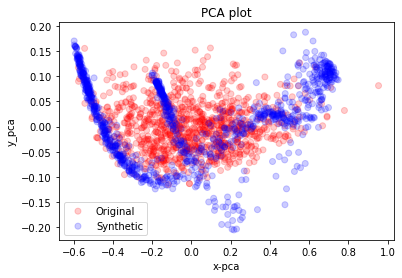

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.000s...
[t-SNE] Computed neighbors for 2000 samples in 0.123s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.024270
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.098969
[t-SNE] KL divergence after 300 iterations: 0.722707


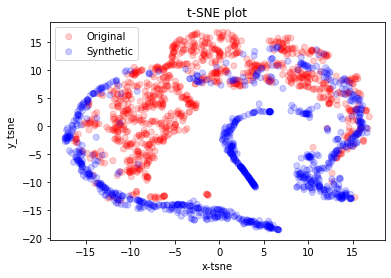

In [13]:
visualization(train_data, generated_data, 'pca')
visualization(train_data, generated_data, 'tsne')

In [14]:
!mv ./pca-results-sines-sce2-wTest-0-005.png ./figures_timegan_sce2_wTest
!mv ./tsne-results-sines-sce2-wTest-0-005.png ./figures_timegan_sce2_wTest

mv: cannot stat './pca-results-sines-sce2-wTest-0-005.png': No such file or directory
mv: cannot stat './tsne-results-sines-sce2-wTest-0-005.png': No such file or directory
